#             Coursera Capstone Project : the battle of neighborhood
1. **Introduction :**<br>
I have been living in Paris for over a year now, and as in all major cities, it is always difficult for newcomers to find the best area to live in, so I will try to group the neighborhoods of Paris according to their venues, I’ll also try to price of rent, which can help people trying to find new places to understand the city and choose according to their preferences and budget,
![image](paris_image.jpg)<br>

2. **Data of Paris :** <br>
I will be using data from a website published by city council of paris : <br>
https://opendata.paris.fr/explore/dataset/quartier_paris/export/ <br>
2 json files contains the list of districts, neighborhood of Paris,geospacial coordonates and also the price of rent euro per meter square, I will be using also Foursquare API to get the venues of each neighbourhood.


In [846]:
#importing useful libraries 
import pandas as pd
import json 
from pandas.io.json import json_normalize
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests
import json 
from pandas.io.json import json_normalize
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import pgeocode
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

In [1135]:
#importing data ( neighborhood, district, and geospacial coordinates)
with open('quartier_paris.json') as f:
    paris_json = json.load(f)
paris=[]
for i in range(len(paris_json)) :
    paris.append([paris_json[i]['fields']['c_ar'],paris_json[i]['fields']['l_qu'],paris_json[i]['fields']['geom_x_y'][0],paris_json[i]['fields']['geom_x_y'][1]])    
paris_data=pd.DataFrame(paris,columns=['District','Neighborhood','Latitude','Longitude'])
paris_data.head()

,District,Neighborhood,Latitude,Longitude
0,9,Rochechouart,48.879812,2.344861
1,12,Bercy,48.835209,2.386210
2,1,Halles,48.862289,2.344899
3,2,Mail,48.868008,2.344699
4,2,Bonne-Nouvelle,48.867150,2.350080


In [1136]:
#Combining Neighbourhoods in the same District
paris_data_dis=pd.merge(paris_data.groupby('District')['Neighborhood'].apply(','.join).reset_index(),
                    paris_data.groupby('District')[['Latitude','Longitude']].mean().reset_index(),on='District')
paris_data_dis.head()

,District,Neighborhood,Latitude,Longitude
0,1,"Halles,Saint-Germain-l'Auxerrois,Place-Vendôme...",48.863654,2.336175
1,2,"Mail,Bonne-Nouvelle,Vivienne,Gaillon",48.868391,2.341918
2,3,"Enfants-Rouges,Sainte-Avoie,Arts-et-Métiers,Ar...",48.863027,2.359566
3,4,"Saint-Gervais,Arsenal,Saint-Merri,Notre-Dame",48.854680,2.356843
4,5,"Jardin-des-Plantes,Saint-Victor,Val-de-Grâce,S...",48.845083,2.350149


In [1186]:
# Importing the data of rent of every neighborhood (the price of rent is euro per meter square)
with open('logement-encadrement-des-loyers.json') as f:
    paris_rent_json = json.load(f)
paris_rent=[]
for i in range(len(paris_rent_json)) :
    paris_rent.append([paris_rent_json[i]['fields']['nom_quartier'],paris_rent_json[i]['fields']['ref']])    
paris_rent_df=pd.DataFrame(paris_rent,columns=['Neighborhood','Rent'])
# grouping by neighborhood
paris_rent_df=paris_rent_df.groupby('Neighborhood')['Rent'].mean().reset_index()
paris_rent_df.head()

,Neighborhood,Rent
0,Amérique,20.600000
1,Archives,26.659375
2,Arsenal,27.915625
3,Arts-et-Metiers,26.659375
4,Auteuil,25.137500


In [1187]:
#finding rent by District
paris_rent_df=pd.merge(paris_rent_df,paris_data[['District','Neighborhood']],on='Neighborhood')
paris_rent_dis=paris_rent_df.groupby('District')['Rent'].mean().reset_index()

In [1138]:
address = 'Paris'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [1139]:
# create map of Paris using latitude and longitude values
map_Paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, district, neighborhood in zip(paris_data_dis['Latitude'], paris_data_dis['Longitude'], paris_data_dis['District'], paris_data_dis['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Paris)  
    
map_Paris.save("map_Paris.html")

In [1140]:
# Foursquare credentials

CLIENT_ID = 'L32DV1DWRYP50KSHYDP3UYAUBHBVCOKZUGLBHOTJUDGQR4HA' # my Foursquare ID
CLIENT_SECRET = 'URGVQLDGVIEFHZZ01JRUOXSK2RUVZOLO5YI5MXLTT30S1BS0' # my Foursquare Secret
VERSION = '20200202' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: L32DV1DWRYP50KSHYDP3UYAUBHBVCOKZUGLBHOTJUDGQR4HA
CLIENT_SECRET:URGVQLDGVIEFHZZ01JRUOXSK2RUVZOLO5YI5MXLTT30S1BS0


In [1142]:
#function to get nearby venues of each neighbourhood of toronto
LIMIT=100
radius=500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
       
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [1143]:
paris_venues = getNearbyVenues(names=paris_data_dis['Neighborhood'],
                                 latitudes=paris_data_dis['Latitude'],
                                 longitudes=paris_data_dis['Longitude'])

Halles,Saint-Germain-l'Auxerrois,Place-Vendôme,Palais-Royal
Mail,Bonne-Nouvelle,Vivienne,Gaillon
Enfants-Rouges,Sainte-Avoie,Arts-et-Métiers,Archives
Saint-Gervais,Arsenal,Saint-Merri,Notre-Dame
Jardin-des-Plantes,Saint-Victor,Val-de-Grâce,Sorbonne
Saint-Germain-des-Prés,Notre-Dame-des-Champs,Monnaie,Odéon
Saint-Thomas-d'Aquin,Invalides,Gros-Caillou,Ecole-Militaire
Madeleine,Champs-Elysées,Faubourg-du-Roule,Europe
Rochechouart,Faubourg-Montmartre,Saint-Georges,Chaussée-d'Antin
Saint-Vincent-de-Paul,Porte-Saint-Denis,Hôpital-Saint-Louis,Porte-Saint-Martin
Saint-Ambroise,Roquette,Folie-Méricourt,Sainte-Marguerite
Bercy,Bel-Air,Picpus,Quinze-Vingts
Gare,Salpêtrière,Maison-Blanche,Croulebarbe
Montparnasse,Plaisance,Petit-Montrouge,Parc-de-Montsouris
Javel,Necker,Grenelle,Saint-Lambert
Muette,Chaillot,Porte-Dauphine,Auteuil
Plaine de Monceaux,Ternes,Epinettes,Batignolles
Clignancourt,Goutte-d'Or,Grandes-Carrières,La Chapelle
Villette,Amérique,Pont-de-Flandre,Combat
Belleville,Charonne,Saint

In [1162]:
#filtring the venues that we will be using for our choice 
Features=['Restaurant','Theater','Hotel','Station','Store','Gym','Bar','Pub','market','Club','Park','Shop','Art','Caf']
paris_venues_filtre=paris_venues.groupby('Venue Category').filter(lambda x : len(x)>1)
paris_venues_filtre=paris_venues_filtre[paris_venues_filtre['Venue Category'].str.contains('|'.join(Features))]
paris_venues_filtre['Venue Category'].value_counts()

French Restaurant         177
Hotel                      87
Italian Restaurant         55
Café                       46
Bar                        39
                         ... 
Argentinian Restaurant      2
Toy / Game Store            2
Indie Movie Theater         2
Ethiopian Restaurant        2
Peruvian Restaurant         2
Name: Venue Category, Length: 81, dtype: int64

In [1163]:
#one hot encoding
paris_onehot = pd.get_dummies(paris_venues_filtre[['Venue Category']], prefix="", prefix_sep="")
paris_onehot.head()

,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bar,Beer Bar,Bubble Tea Shop,...,Thai Restaurant,Theater,Toy / Game Store,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1164]:
paris_onehot['Neighborhood'] = paris_venues['Neighborhood']
#paris_onehot['District'] = paris_venues['District']
# moving neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]
paris_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bar,Beer Bar,...,Thai Restaurant,Theater,Toy / Game Store,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
2,"Halles,Saint-Germain-l'Auxerrois,Place-Vendôme...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,"Halles,Saint-Germain-l'Auxerrois,Place-Vendôme...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,"Halles,Saint-Germain-l'Auxerrois,Place-Vendôme...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Halles,Saint-Germain-l'Auxerrois,Place-Vendôme...",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Halles,Saint-Germain-l'Auxerrois,Place-Vendôme...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1165]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bar,Beer Bar,...,Thai Restaurant,Theater,Toy / Game Store,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,"Belleville,Charonne,Saint-Fargeau,Père-Lachaise",0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.153846,0.000000,...,0.000000,0.025641,0.0,0.0,0.0,0.000000,0.000000,0.025641,0.025641,0.0
1,"Bercy,Bel-Air,Picpus,Quinze-Vingts",0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.058824,0.000000,0.058824,0.0
2,"Clignancourt,Goutte-d'Or,Grandes-Carrières,La ...",0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.194444,0.000000,...,0.000000,0.027778,0.0,0.0,0.0,0.027778,0.027778,0.027778,0.027778,0.0
3,"Enfants-Rouges,Sainte-Avoie,Arts-et-Métiers,Ar...",0.0,0.0,0.015625,0.03125,0.015625,0.0,0.000000,0.000000,0.015625,...,0.015625,0.000000,0.0,0.0,0.0,0.015625,0.031250,0.062500,0.000000,0.0
4,"Gare,Salpêtrière,Maison-Blanche,Croulebarbe",0.0,0.0,0.000000,0.00000,0.000000,0.0,0.046512,0.023256,0.000000,...,0.093023,0.000000,0.0,0.0,0.0,0.000000,0.116279,0.000000,0.000000,0.0


In [1166]:
#function to return sorted venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [1167]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']


columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Belleville,Charonne,Saint-Fargeau,Père-Lachaise",Bar,French Restaurant,Italian Restaurant,Café,Japanese Restaurant,Park,Health Food Store,Hotel,Wine Shop,Korean Restaurant
1,"Bercy,Bel-Air,Picpus,Quinze-Vingts",Hotel,Japanese Restaurant,French Restaurant,Park,Wine Shop,Supermarket,Fast Food Restaurant,Food & Drink Shop,Gym / Fitness Center,Café
2,"Clignancourt,Goutte-d'Or,Grandes-Carrières,La ...",Bar,French Restaurant,Convenience Store,Coffee Shop,Café,Italian Restaurant,Park,Indian Restaurant,Mediterranean Restaurant,Fast Food Restaurant
3,"Enfants-Rouges,Sainte-Avoie,Arts-et-Métiers,Ar...",French Restaurant,Coffee Shop,Café,Wine Bar,Japanese Restaurant,Italian Restaurant,Moroccan Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dessert Shop
4,"Gare,Salpêtrière,Maison-Blanche,Croulebarbe",Hotel,Vietnamese Restaurant,French Restaurant,Thai Restaurant,Chinese Restaurant,Juice Bar,Asian Restaurant,Sushi Restaurant,Italian Restaurant,Japanese Restaurant


In [1168]:
#paris_grouped_district=pd.merge(paris_grouped,paris_data[['District','Neighborhood']],on='Neighborhood' )
#paris_grouped_district =paris_grouped_district.groupby('District').mean().reset_index()
#paris_grouped_district_clus=paris_grouped_district.drop(['District'],axis=1)



In [1169]:
#paris_grouped_district = paris_grouped_district[paris_grouped_district.columns.drop(list(paris_grouped_district.filter(regex='Restaurant')))]

In [1170]:
#paris_grouped_district_clus=paris_grouped_district.drop(['District'],axis=1)

# 5. Clustering and Visualizing Neighborhoods

In [1171]:
#finding optimal 'k' with silhouette method
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

paris_grouped_clustering=paris_grouped.drop(['Neighborhood'],axis=1)
# Standardize the data
X = StandardScaler().fit_transform(paris_grouped_clustering)
sil = []
K= range(2,11)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2,11):
  kmeans = KMeans(n_clusters = k,random_state=0).fit(paris_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(paris_grouped_clustering, labels))

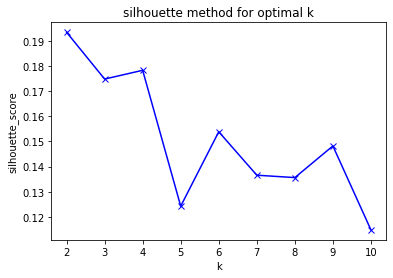

In [1172]:
# according to plot k=3 is the most optimal!!
plt.plot(K,sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette method for optimal k')
plt.show()

In [1173]:
#### setting number of clusters
kclusters = 2
kmeans = KMeans(n_clusters=kclusters, random_state=0,max_iter=500).fit(paris_grouped_clustering)
kmeans.labels_[0:10]

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1])

In [1193]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']=kmeans.labels_
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
paris_merged = paris_data_dis
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
paris_merged.head()

,District,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,1,"Halles,Saint-Germain-l'Auxerrois,Place-Vendôme...",48.863654,2.336175,Japanese Restaurant,French Restaurant,Café,Hotel,Coffee Shop,Ramen Restaurant,Udon Restaurant,Korean Restaurant,Art Museum,Italian Restaurant,1
1,2,"Mail,Bonne-Nouvelle,Vivienne,Gaillon",48.868391,2.341918,French Restaurant,Hotel,Wine Bar,Japanese Restaurant,Cocktail Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Coffee Shop,Women's Store,1
2,3,"Enfants-Rouges,Sainte-Avoie,Arts-et-Métiers,Ar...",48.863027,2.359566,French Restaurant,Coffee Shop,Café,Wine Bar,Japanese Restaurant,Italian Restaurant,Moroccan Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dessert Shop,1
3,4,"Saint-Gervais,Arsenal,Saint-Merri,Notre-Dame",48.854680,2.356843,French Restaurant,Ice Cream Shop,Hotel,Pastry Shop,Thai Restaurant,Wine Bar,Falafel Restaurant,Coffee Shop,Art Gallery,Cocktail Bar,1
4,5,"Jardin-des-Plantes,Saint-Victor,Val-de-Grâce,S...",48.845083,2.350149,French Restaurant,Hotel,Italian Restaurant,Café,Coffee Shop,Pub,Bar,Wine Bar,Asian Restaurant,Falafel Restaurant,1


In [1194]:
#removing Nan!!
paris_merged = paris_merged[np.isfinite(paris_merged['Cluster Labels'])].reset_index()
paris_merged=paris_merged.drop(['index'],axis=1)
paris_merged['Cluster Labels'] = paris_merged['Cluster Labels'].astype(int)

In [1176]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('map_paris_clusters.html')

In [1197]:
#merging paris cluestring data with the rent 
paris_merged=pd.merge(paris_merged,paris_rent_dis,on='District')


In [1198]:
#examining clusters 
## cluster 0!! only displaying heads!! 
paris_merged[paris_merged['Cluster Labels'] == 0].head()

,District,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Rent
6,7,"Saint-Thomas-d'Aquin,Invalides,Gros-Caillou,Ec...",48.855609,2.313651,French Restaurant,Hotel,Café,Italian Restaurant,Art Museum,Coffee Shop,Japanese Restaurant,Korean Restaurant,Metro Station,Cocktail Bar,0,29.575000
7,8,"Madeleine,Champs-Elysées,Faubourg-du-Roule,Europe",48.872656,2.312500,French Restaurant,Hotel,Cocktail Bar,Bar,Art Gallery,Theater,Park,Modern European Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,0,27.743750
8,9,"Rochechouart,Faubourg-Montmartre,Saint-Georges...",48.876807,2.338308,French Restaurant,Hotel,Cocktail Bar,Bar,Italian Restaurant,Japanese Restaurant,Cheese Shop,Café,Gym / Fitness Center,Wine Bar,0,25.628125
11,12,"Bercy,Bel-Air,Picpus,Quinze-Vingts",48.837620,2.405654,Hotel,Japanese Restaurant,French Restaurant,Park,Wine Shop,Supermarket,Fast Food Restaurant,Food & Drink Shop,Gym / Fitness Center,Café,0,22.859375
13,14,"Montparnasse,Plaisance,Petit-Montrouge,Parc-de...",48.829511,2.327649,French Restaurant,Sushi Restaurant,Supermarket,Hotel,Ice Cream Shop,Fast Food Restaurant,Food & Drink Shop,Café,Convenience Store,Bar,0,24.403906


In [1196]:
## cluster 1!! only displaying heads!! 
paris_merged[paris_merged['Cluster Labels'] == 1].head()

,District,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,1,"Halles,Saint-Germain-l'Auxerrois,Place-Vendôme...",48.863654,2.336175,Japanese Restaurant,French Restaurant,Café,Hotel,Coffee Shop,Ramen Restaurant,Udon Restaurant,Korean Restaurant,Art Museum,Italian Restaurant,1
1,2,"Mail,Bonne-Nouvelle,Vivienne,Gaillon",48.868391,2.341918,French Restaurant,Hotel,Wine Bar,Japanese Restaurant,Cocktail Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Coffee Shop,Women's Store,1
2,3,"Enfants-Rouges,Sainte-Avoie,Arts-et-Métiers,Ar...",48.863027,2.359566,French Restaurant,Coffee Shop,Café,Wine Bar,Japanese Restaurant,Italian Restaurant,Moroccan Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dessert Shop,1
3,4,"Saint-Gervais,Arsenal,Saint-Merri,Notre-Dame",48.854680,2.356843,French Restaurant,Ice Cream Shop,Hotel,Pastry Shop,Thai Restaurant,Wine Bar,Falafel Restaurant,Coffee Shop,Art Gallery,Cocktail Bar,1
4,5,"Jardin-des-Plantes,Saint-Victor,Val-de-Grâce,S...",48.845083,2.350149,French Restaurant,Hotel,Italian Restaurant,Café,Coffee Shop,Pub,Bar,Wine Bar,Asian Restaurant,Falafel Restaurant,1


3. **Analysing  the clusters :** <br>
By analyzing the clusters we can see that cluster 1 is more residential since it contains lots of shops and a variety of restaurants while cluster 0 is more commercial / touristic and contains many hotels and french restaurant

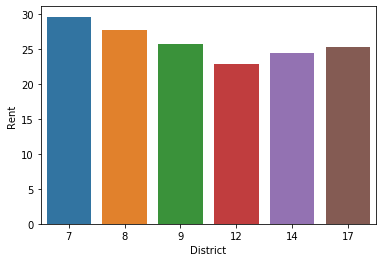

In [1202]:
#visualiation of the cheapest rent district of cluster 0
sns.barplot(x='District',y='Rent',data=paris_merged[paris_merged['Cluster Labels'] == 0])


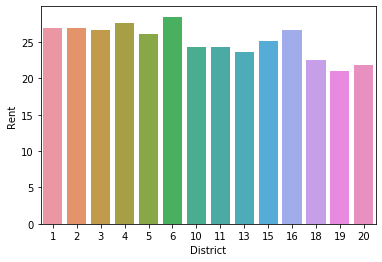

In [1201]:
#visualiation of the cheapest rent district of cluster 1

sns.barplot(x='District',y='Rent',data=paris_merged[paris_merged['Cluster Labels'] == 1])


4. **Conclusion :** <br>
With this 2 figures and the maps we can find similaire District, and compare their prices of rent, we can also change the type of venues, this way we will only compare venues that we are interessed in. 